<br/><br/><br/>

# VOLTRON AI : Recommend books to users based on their history and preferences.
## Model used : Two tower neural network.

For our personalized recommendations, we’re going to be using a variant of collaborative filtering. 
We’ll use something called an embedding to build a "profile" of the interactions between users and books. This technique falls neither in the collaborative nor content-based approach. It’s more of a hybrid approach.
To do this, we’re going to leverage existing data of books, users, and ratings given by users. A special kind of neural network layer called an embedding is then trained on this interaction, learning the similarity between books in something called an embedding space.
This embedding space helps the neural network better understand the interaction between books and users, and we can leverage this knowledge, combined with the user ratings of each book, to train a neural network. This is a classic regression approach, where the input is the learned embedding of book-user interaction, and the target/labels are book ratings given by the users.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
from IPython.display import display
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow.keras as tf
warnings.filterwarnings('ignore')
%matplotlib inline


<br/><br/><br/>

We will use goodbooks-10k dataset to train the model.


The first data file we will use is for ratings.
We can see that the ratings dataset contains just three columns: book_id, user_id, and the corresponding rating given by the user.

This is what we’ll feed into our embedding layer, so as to learn an efficient mapping of users to books.

In [168]:
ratings_df = pd.read_csv("book-data/ratings.csv") 
books_df = pd.read_csv("book-data/books.csv")

ratings_df.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


<br/><br/><br/>
The second data file is for books metadata. We’ll use this data when making predictions

In [167]:
pd.options.display.max_columns = None
books_df.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...



<br/><br/><br/>
Checking our data : 

We can see that there are over 5.9M ratings given by 53K users to 10K books. This means different users have rated several books, and each book has been rated by several users.

We can see that there are no missing values in the dataset, and each column is already in numerical format. So we are good to go as our preprocessing is done.

In [4]:
print(ratings_df.shape)
print(ratings_df.user_id.nunique())
print(ratings_df.book_id.nunique())
print(ratings_df.isna().sum())

(5976479, 3)
53424
10000
user_id    0
book_id    0
rating     0
dtype: int64



<br/><br/><br/>

Splitting the dataset :
We’ll split the data into train and test sets.
We use a test size of 0.2 (20%) when splitting the dataset

In [5]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest = train_test_split(ratings_df, test_size=0.2, random_state=1)
print(f"Shape of train data: {Xtrain.shape}")
print(f"Shape of test data: {Xtest.shape}")

Shape of train data: (4781183, 3)
Shape of test data: (1195296, 3)


<br/><br/><br/>

Building the model :
    
In our neural network we will have two input embedding layers. The first embedding layer accepts the books, and the second the users. The embeddings are trained separately and then combined before going through the dense layer.
The embedding is like the mapping of an entity (book, user) to a vector of real numbers in a smaller dimension

First, let’s get the unique users and books in the dataset—this forms the vocabulary for our embeddings.

In [6]:
#Get the number of unique entities in books and users columns
nbook_id = ratings_df.book_id.nunique()
nuser_id = ratings_df.user_id.nunique()

<br/><br/><br/>
First we create an input layer that will be fed a 1D array of book IDs. 
We create an embedding layer with a shape of (number of unique books + 1, 15). The +1 to the # of unique books because the embedding layers need an extra row for books that that are not in the training dataset. Let's call these the out-of-vocabulary entities.
(15) is an arbitrary dimension we chose. This number depends on how large we want the embedding layer to be.

Notice that we append the input layer to the end of the book embedding layer in order to pass the output of the input layer to the embedding layer.

Same as we did for books, but this time for the users. We create an input that accepts the users as a 1D vector, and then we create the user embeddings.

Finally we simply concatenate the books and the user embedding layer together, and add a single dense layer of 128. For the final layer of the model, we use a single node as output, because we’re predicting the ratings given to each book.

note : We'll use Keras functional API. It's is a way to create models that are more flexible than the tf.keras.Sequential API. The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.

In [31]:
#Book input network
input_books = tf.layers.Input(shape=[1])
dense = tf.layers.Dense(32, activation="relu")
xx = dense(input_books)
embed_books = tf.layers.Embedding(nbook_id + 1,15)(xx)
books_out = tf.layers.Flatten()(embed_books)

#user input network
input_users = tf.layers.Input(shape=[1])
dense = tf.layers.Dense(32, activation="relu")
yy = dense(input_users)
embed_users = tf.layers.Embedding(nuser_id + 1,15)(yy)
users_out = tf.layers.Flatten()(embed_users)

conc_layer = tf.layers.Concatenate()([books_out, users_out])
x = tf.layers.Dense(128, activation='relu')(conc_layer)
#x = tf.layers.Dropout(0.3)(x)
x = tf.layers.Dense(128, activation='relu')(x)
x_out = x = tf.layers.Dense(1, activation='relu')(x)
model = tf.Model([input_books, input_users], x_out)

<br/><br/><br/>
We ll use an Adam optimizer here with a learning rate of 0.001, and mean squared error as the loss function.

In [32]:
opt = tf.optimizers.Adam(learning_rate=0.002)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_27 (Dense)                (None, 32)           64          input_13[0][0]                   
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 32)           64          input_14[0][0]                   
____________________________________________________________________________________________

<br/><br/><br/>
The fit parameter expects two arrays as input, list of books + users IDs, and ratings as target. 
Batch size of 64 for faster training on a large dataset. 

We also pass our test set to the validation parameter so that Keras can calculate the performance on previously unseen data at the end of every epoch. 

We plot the metrics in real time as the model is training.
we notice constant decrease in training loss, but little improvement in validation loss. Classic case of overfitting that we can improve with hyperparameter tuning.

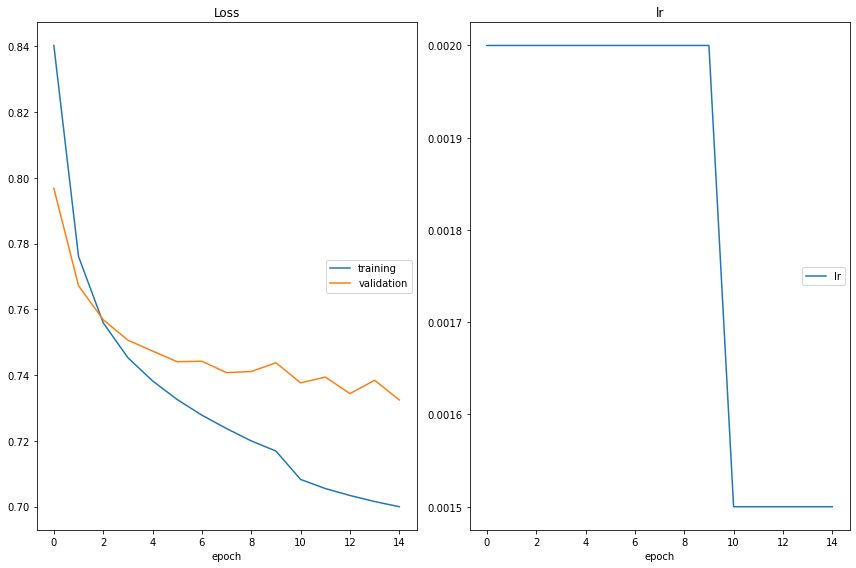

Loss
	training         	 (min:    0.700, max:    0.840, cur:    0.700)
	validation       	 (min:    0.732, max:    0.797, cur:    0.732)
lr
	lr               	 (min:    0.002, max:    0.002, cur:    0.002)


In [33]:

    # Create a callback to stop the model if overfits
    early_stop = EarlyStopping(monitor='val_loss',patience=3) 
    lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.75,
                                  patience=2,
                                  verbose=2,
                                  mode='auto')


hist = model.fit([Xtrain.book_id, Xtrain.user_id], Xtrain.rating, 
                 batch_size=128, 
                 epochs=15, 
                 verbose=1,
                 validation_data=([Xtest.book_id, Xtest.user_id], Xtest.rating),
                 callbacks=[early_stop,lr_reduce,PlotLossesKeras()])

<br/><br/><br/>
We save the model

In [35]:
#save the model
model.save('model')

INFO:tensorflow:Assets written to: model/assets


<br/><br/><br/>
In order to visualise our embedding layer and see how books are clustered together in the embedding space, we'll use TensorFlow Embedding Projector.

The shape of the book embedding layer is (10001, 15). This means that thee model was able to map each book to a 15 col vector. We will save this vector, as well as the corresponding book’s title, and upload them to the TensorFlow Embedding Projector.

In [37]:
# Extract embeddings
book_em = model.get_layer('embedding')
book_em_weights = book_em.get_weights()[0]
book_em_weights.shape

(10001, 15)

<br/><br/><br/>
We get the book titles from the books.csv dataset:
We first make a copy of the book DataFrame, and set the column book_id as the index so we can easily access it

In [38]:
books_df_copy = books_df.copy()
books_df_copy = books_df_copy.set_index("book_id")

<br/><br/><br/>
Then we’ll get all the unique book IDs, and then write them to a tsv file:

We simply loop over all the unique book IDs, retrieve their titles, and then write them to the corresponding tsv file. We'll have two tsv files, one containing the embedding weights, and the other containing the corresponding book title.
We can then load both tsv files in TensorFlow Embedding Projector.
Books closer in the embedding space tend to be similar, so this trained embedding can be effectively used to recommend similar books.

We could use the trained embedding to simply extract the closest books to a given input but a recommendation engine based on similar books (content-based Filtering)is not enough for our exercise.

We’ll be determining recommendations based on user ratings of other books (collaborative filtering).
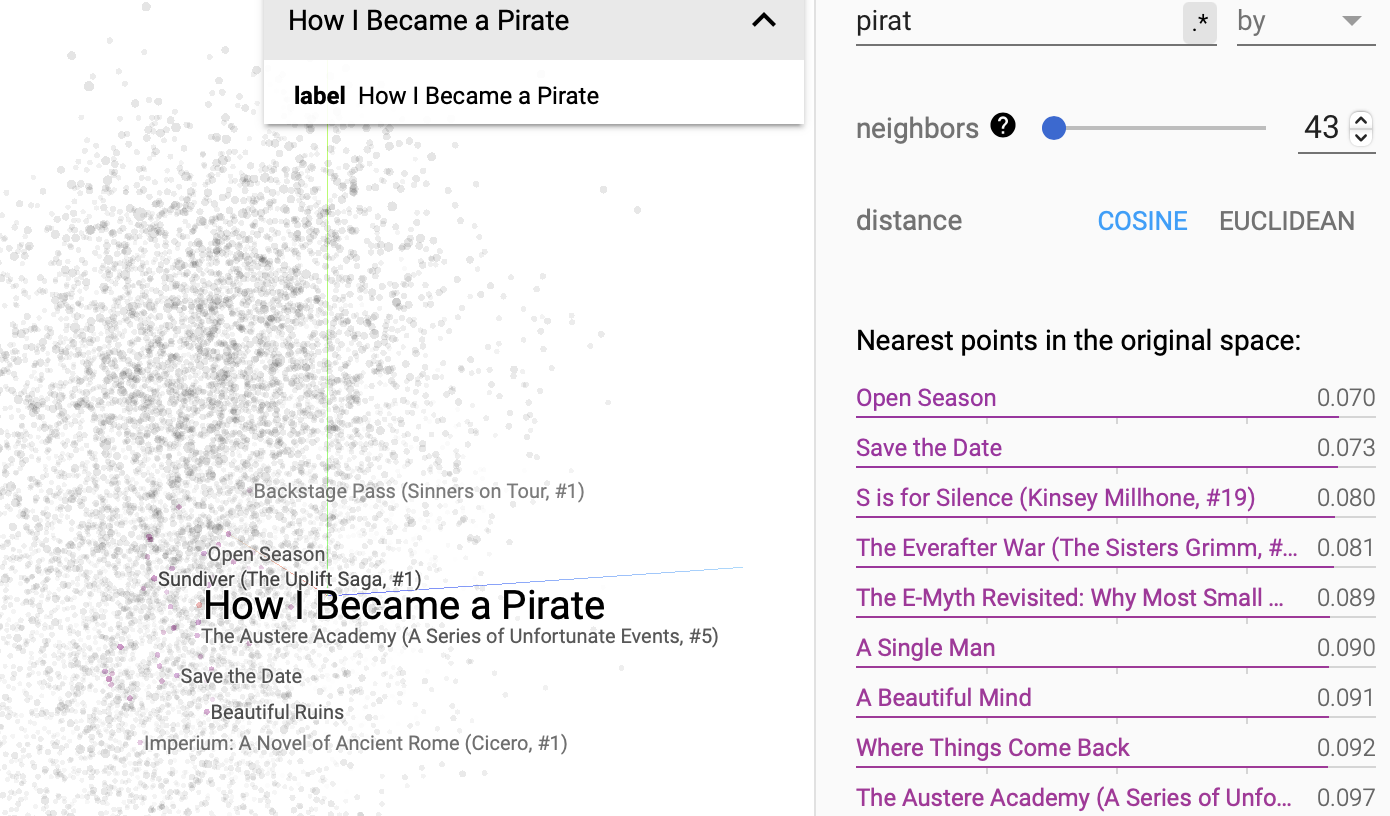

In [39]:
b_id =list(ratings_df.book_id.unique())
b_id.remove(10000)
dict_map = {}
for i in b_id:
    dict_map[i] = books_df_copy.iloc[i]['title']
    
out_v = open('vecs.tsv', 'w')
out_m = open('meta.tsv', 'w')
for i in b_id:
    book = dict_map[i]
    embeddings = book_em_weights[i]
    out_m.write(book + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    
out_v.close()
out_m.close()

<br/><br/><br/>
In order to make recommendations, we need to pass in the list of books and a user to the model. 
The model will make a prediction of a rating it thinks the user will give to books based on its understanding of the user.
These ratings are then sorted in ascending order. If we want to recommend 10 books to a user, we’ll pass in a list of books to the model to predict ratings it feels the user will give to those books. Then we pick the top 10 of these ratings and recommend those books to the user.

<br/>
In the code below, we first get all book IDs and save them in an array. 
Then we create another array with the same length as the book array, but with the same user ID all the way down. 
Next, we pass it to the model, who is expecting two inputs (Books and User). It returns a list of predicted ratings for each book.

In [169]:
#Making recommendations for user 100
book_arr = np.array(b_id) #get all book IDs
user = np.array([100 for i in range(len(b_id))])
pred = model.predict([book_arr, user])
print(pred)

[[3.676931 ]
 [2.8488145]
 [3.2717986]
 ...
 [3.3531706]
 [3.5964868]
 [3.2168062]]


<br/><br/><br/>
We sort the array in ordeer to retrieve the index of the top 5 ratings. 
<br/>Then, with the index, we can retrieve the corresponding books from the dataset:

In [170]:
pred = pred.reshape(-1) #reshape to single dimension
pred_ids = (-pred).argsort()[0:5]
print(pred_ids)

[1534 3261  479 6869  974]


<br/><br/><br/>

Finally we use the index to retrieve the corresponding books from books.csv DataFrame:<br/>
These are the top 5 sugestions for this user.

In [164]:

del books_df["ratings_count"]
del books_df["work_ratings_count"]
del books_df["work_text_reviews_count"]
del books_df["ratings_1"]
del books_df["ratings_2"]
del books_df["ratings_3"]
del books_df["ratings_4"]
del books_df["ratings_5"]
del books_df["small_image_url"]
del books_df["goodreads_book_id"]
del books_df["best_book_id"]
del books_df["work_id"]
del books_df["books_count"]
del books_df["isbn13"]
del books_df["title"]
del books_df["language_code"]

books_df.iloc[pred_ids]


,book_id,isbn,authors,original_publication_year,original_title,average_rating,image_url
1534,1535,316155608,James Patterson,2006.0,Saving The World and Other Extreme Sports,4.16,https://s.gr-assets.com/assets/nophoto/book/11...
3261,3262,393332144,Patricia Highsmith,1955.0,The Talented Mr. Ripley,3.93,https://s.gr-assets.com/assets/nophoto/book/11...
479,480,440238153,Philip Pullman,2000.0,The Amber Spyglass,4.06,https://images.gr-assets.com/books/1329189152m...
6869,6870,307263940,Anne Tyler,2006.0,Digging to America,3.53,https://images.gr-assets.com/books/1327901292m...
974,975,393322238,"Vincent Bugliosi, Curt Gentry",1974.0,Helter Skelter: The True Story of The Manson M...,4.00,https://s.gr-assets.com/assets/nophoto/book/11...
